# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'data/train.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = 43

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import random
import numpy as np
import matplotlib.pyplot as plt
import csv
import cv2
from sklearn.utils import shuffle

%matplotlib inline

# load mapping of sign number to name
import csv
sign_mapping = dict()
with open('./signnames.csv', newline='') as csvfile:
    csvreader = csv.reader(csvfile)
    csvreader.__next__()
    for row in csvreader:
        sign_mapping[int(row[0])] = row[1] 
    
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

def bucket_images(X_train, y_train):
    x,y = shuffle(X_train, y_train)
    bucket = dict()
    for xi, yi in zip(x,y):
        if yi in bucket and len(bucket[yi]) < 10:
            bucket[yi].append(xi)
            pass
        else:
            bucket[yi] = []
            bucket[yi].append(xi)
            pass
        pass
    return bucket
buckets = bucket_images(X_train, y_train)

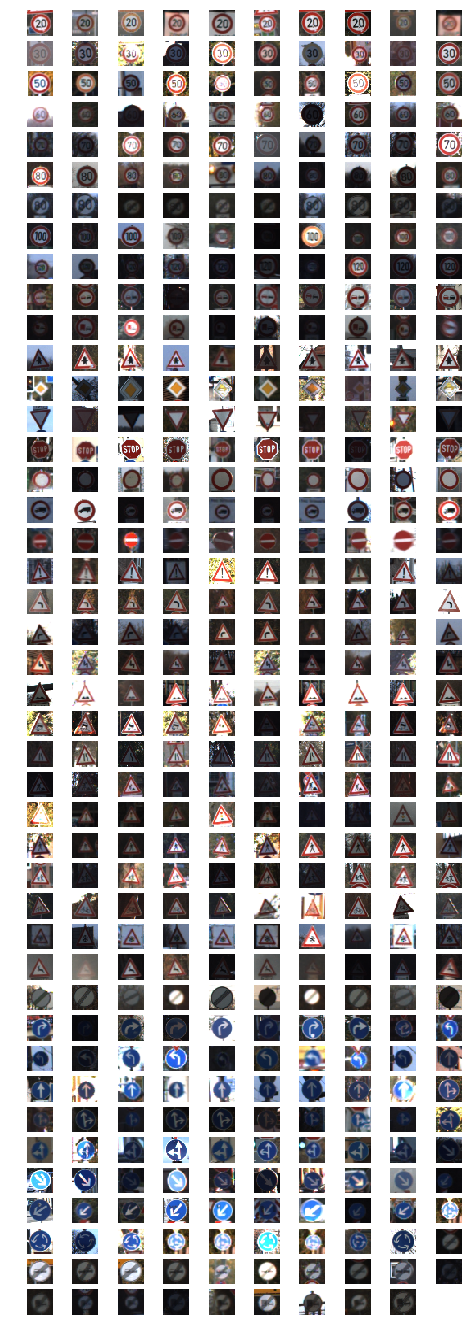

28412 24 Road narrows on the right
Histogram of training data distribution


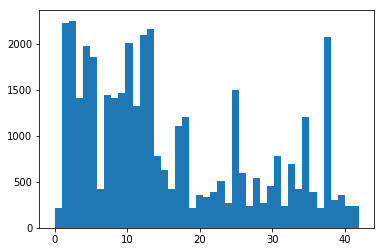

In [4]:
fig = plt.figure(figsize=(8, 24))

n = 1
breakLoop = 0
for bi in buckets:
    for image in buckets[bi]:
        if n <= 430:
            a = fig.add_subplot(43, 10, n)
            plt.axis('off')
            plt.imshow(image)
            n = n + 1
            pass
        pass
    pass

plt.show()

print(index,y_train[index],sign_mapping[y_train[index]])
print("============")
print("Histogram of training data distribution")
t1 = plt.hist(y_train, n_classes)

The first plot randomly samples 10 images from each sign type. It's used to get an overview of the full data set. 
The training set isn't uniformly distributed as can be seen from the histogram. 
From the sampling of images for each traffic sign type, some images are darker. It's possible that some sort of normalization can be applied to brighten the images

----
## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

def normalize (data):
    # normalize around 128
    out = np.zeros_like(data, dtype=float)
#     # alternative histogram equalization
#     print(out.shape)
#     clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
#     i = 0
#     for img in data:
#         lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
#         l, a, b = cv2.split(lab)
#         cl = clahe.apply(l)
#         limg = cv2.merge((cl,a,b))
#         out[i] = cl
#         i = i + 1
    # simply normalize values between 0 and 1
    out[...,0] = (data[...,0] - 128.0) / 128.0
    out[...,1] = (data[...,1] - 128.0) / 128.0
    out[...,2] = (data[...,2] - 128.0) / 128.0
    return out

X_train_norm = normalize(X_train)
X_test_norm = normalize(X_test)

## Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
I simply normalized the data to be between 0 and 1 by centering each pixel around 128 since the lectures talked about ensuring that the data is centered around small values. This ensures loss minimizing algorithms like SGD can be numerically stable when running

I chose not to use only gray scale. For something like signs, color would seem to make a difference as well. Signs can be quite similar, but a difference in major colors can make identification easier. 

Also playing around and using just grayscale didn't improve the validation accuracy.

In [7]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

# shuffle the data
# select 30% as validation set

from sklearn.utils import shuffle
import math

X_train_shuffle, y_train_shuffle = shuffle(X_train_norm, y_train)
train_size = math.ceil(n_train * 0.7)
X_train_final = X_train_shuffle[0:train_size]
y_train_final = y_train_shuffle[0:train_size]

X_validate_norm = X_train_shuffle[train_size+1:]
y_validate = y_train_shuffle[train_size+1:]

print("Training Set Size", len(X_train_final), len(y_train_final))
print("Validation Set Size",len(X_validate_norm), len(y_validate))

Training Set Size 27447 27447
Validation Set Size 11761 11761


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
I simply shuffled the data and selected the last 30% as the validation set. I didn't choose to generate additional data. If I had time, some approaches would be to use perspective modified images. Lower or increased brightness. Shift around the images a little bit. shrink or increase the size of the sign in the image

In [8]:
from tensorflow.contrib.layers import flatten

def LeNet(x, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0.00
    sigma = 0.10
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation & dropout
    fc1    = tf.nn.relu(fc1)
    fc1    = tf.nn.dropout(fc1, keep_prob)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
This is effectively the LeNet optimizer from the lab.

The only additional tweak on my part was to add a drop out layer 3 and layer 4. I also had to tweak the input layer to be size 32x32x3

# Train your model here.
### Feel free to use as many code cells as needed.

In [9]:
import tensorflow as tf

EPOCHS = 20
BATCH_SIZE = 32
rate = 0.0008
prob = 0.70

keep_prob = tf.placeholder(tf.float32)
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)


logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_final, y_train_final = shuffle(X_train_final, y_train_final)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_final[offset:end], y_train_final[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:prob})
            
        validation_accuracy = evaluate(X_validate_norm, y_validate)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.794

EPOCH 2 ...
Validation Accuracy = 0.912

EPOCH 3 ...
Validation Accuracy = 0.952

EPOCH 4 ...
Validation Accuracy = 0.955

EPOCH 5 ...
Validation Accuracy = 0.954

EPOCH 6 ...
Validation Accuracy = 0.971

EPOCH 7 ...
Validation Accuracy = 0.949

EPOCH 8 ...
Validation Accuracy = 0.973

EPOCH 9 ...
Validation Accuracy = 0.973

EPOCH 10 ...
Validation Accuracy = 0.969

EPOCH 11 ...
Validation Accuracy = 0.978

EPOCH 12 ...
Validation Accuracy = 0.952

EPOCH 13 ...
Validation Accuracy = 0.984

EPOCH 14 ...
Validation Accuracy = 0.982

EPOCH 15 ...
Validation Accuracy = 0.981

EPOCH 16 ...
Validation Accuracy = 0.976

EPOCH 17 ...
Validation Accuracy = 0.959

EPOCH 18 ...
Validation Accuracy = 0.986

EPOCH 19 ...
Validation Accuracy = 0.984

EPOCH 20 ...
Validation Accuracy = 0.985

Model saved


## Check against test set

In [11]:
## Validate against test set
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_norm, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.936


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
The optimizer type selected was the default optimizer (AdamOptimizer) from the LeNet lab.
Used a smaller batch size to 32. It yielded higher validation accuracy
The learning speed didn't seem to make much of a differnce, so it was left unchanged

Picked epochs of 20. Higher epochs didn't yield increased validation accuracy
Drop out propbability of 0.7 was selected by trial and error. too low and the network wasn't able to train too well. 0.7 seemed to give the best validation accuracy

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
I picked the known LeNet lab architecture which has been used to solve similar traffic sign recognition problems. 
The addition of dropout was used to minimize overfitting.

---
## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

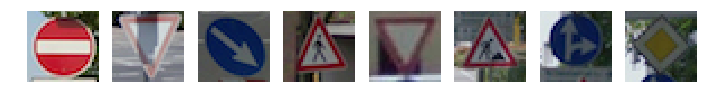

['No entry', 'Yield', 'Keep right', 'Pedestrians', 'Yield', 'Road work', 'Go straight or right', 'Priority road']


In [12]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
file_list = ['t1.ppm', '2-yield.jpg', '3-go-right-38.jpg', '4-pedestrians-27.jpg', 
             '5-yield-13.jpg', '6-roadwork-25.jpg', '7-gostraightright-37.jpg', '8-priorityroad-12.jpg']
y_extra = [17, 13, 38, 27, 13, 25, 36, 12]

# file_list = ['t1.ppm', '3-go-right-38.jpg', '4-pedestrians-27.jpg', 
#              '5-yield-13.jpg', '6-roadwork-25.jpg']
# y_extra = [17, 38, 27, 13, 25]

# no entry
extra_test = np.zeros((len(file_list), 32, 32, 3))

fig = plt.figure(figsize=(12, 4))
i = 0
for testImg in file_list:
    image = cv2.imread("extra/" + testImg)
    #openCV loads in BGR format. We've trained on RGB. Color matters
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    extra_test[i] = image
    fig.add_subplot(1, 8, i+1)
    plt.axis('off')
    plt.imshow(image)
    i = i + 1

plt.show()
expected_signs = []
for yi in y_extra:
    expected_signs.append(sign_mapping[yi])
    pass
print (expected_signs)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

The first yield sign has a shadow over the sign which could be interesting. Some of the signs are not head on, but from another perspective and distorted. These were collected from google street view images in Germany. 

The plot above shows the sample images and their respective expected classifications

In [17]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(extra_test, y_extra)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.875


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

The additional images were selected from google street view on random roads in Frankfurt. The model performed with a 87.5% accuracy on the selected images.

Initially the accuracy was coming out to be under 50%, but then I noticed that the cv2.imread api was loading images in BGR format, while the network was trained on RGB. Transforming the images to RGB after reading from imread improved the accuracy.

We explore the inaccuracies in the next section

In [15]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed
softmax = None

def get_softmax_values(X_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x = X_data[offset:offset+BATCH_SIZE]
        softmax = tf.nn.softmax(logits)
        accuracy = sess.run(tf.nn.top_k(softmax, k=3), feed_dict={x: batch_x, keep_prob:1.0})
    return accuracy

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    softmax = get_softmax_values(normalize(extra_test))

In [16]:
import pprint
import math
import collections
pp = pprint.PrettyPrinter(indent=2)

def convert_to_words(smax, expected_signs):
    '''
    Want to generate the following
    Expected type: <english>
    Actual Type: {
        "type1": prob
        "type2": prob2
        "type3": prob3
    }
    '''
    result = []
    for indices, sign, values in zip(smax.indices, expected_signs, smax.values):
        y = collections.OrderedDict()
        y[sign_mapping[indices[0]]] = math.floor(values[0] * 1000) / 1000.0
        y[sign_mapping[indices[1]]] = math.floor(values[1] * 1000) / 1000.0
        y[sign_mapping[indices[2]]] = math.floor(values[2] * 1000) / 1000.0
        x = {
            sign : y
        }
        result.append(x)
        pass
    return result

pp.pprint(convert_to_words(softmax, expected_signs))

[ { 'No entry': OrderedDict([ ('No entry', 0.999),
                              ('Stop', 0.0),
                              ('Speed limit (20km/h)', 0.0)])},
  { 'Yield': OrderedDict([ ('Yield', 0.999),
                           ('Priority road', 0.0),
                           ('Road work', 0.0)])},
  { 'Keep right': OrderedDict([ ('Keep right', 1.0),
                                ('Go straight or right', 0.0),
                                ('Yield', 0.0)])},
  { 'Pedestrians': OrderedDict([ ('General caution', 0.848),
                                 ('Pedestrians', 0.093),
                                 ('Road narrows on the right', 0.058)])},
  { 'Yield': OrderedDict([ ('Yield', 1.0),
                           ('Ahead only', 0.0),
                           ('No vehicles', 0.0)])},
  { 'Road work': OrderedDict([ ('Road work', 1.0),
                               ('Beware of ice/snow', 0.0),
                               ('Speed limit (80km/h)', 0.0)])},
  { 'Go straight

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

**Answer:**

The data above shows what the softmax probabilities were compared to the expected image type. 
So for example, the first image is about pedestrians, but it got tagged as General caution with a certainty of 85%
```
{ 'Pedestrians': OrderedDict([ ('General caution', 0.848),
                                 ('Pedestrians', 0.093),
                                 ('Road narrows on the right', 0.058)])},
```
So even though the prediction was wrong, but the right answer is the second most probable prediction at 10%.
Both 'General caution' and 'Pedestrians' are triangles with a red boundary. The General caution sign has an exclamation mark in it. It's a bit confusing that an exclamation mark can be considered similar to a stick person walking accross.

In most cases where the predictions were right, they were very certain as well (i.e. close 1.0 probability). 

In once case though, the prediction was not as certain
```
{ 'Go straight or right': OrderedDict([ ('Go straight or right', 0.583),
                                      ('Turn left ahead', 0.374),
                                      ('Turn right ahead', 0.035)])},
```
For this 'go straight or right' sign, the certainty was only 58%. The next prediction was at 37.4% for 'turn left ahead'. It's weird that turn left ahead was the next most certain prediction. The signs both have blue background, but the arrow is an different direction. I would have expect the second prediction to be "turn right ahead".

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.